In [1]:
from importlib import import_module
from snntoolbox.parsing.utils import *
from snntoolbox.parsing.model_libs.keras_input_lib import *
from snntoolbox.bin.utils import *
from snntoolbox.conversion.utils import normalize_parameters
from snntoolbox.datasets.utils import get_dataset
from snntoolbox.simulation.utils import *
from snntoolbox.simulation.target_simulators.brian2_target_sim import *

Using TensorFlow backend.
/home/wolin/.conda/envs/tf2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wolin/.conda/envs/tf2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wolin/.conda/envs/tf2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wolin/.conda/envs/tf2/lib/python3.7

In [2]:
import numpy as np

In [3]:
def run(snn, **test_set):
            return snn.run(**test_set)

In [4]:
model_path = "/home/wolin/snn_toolbox/forgetting/full/"

In [5]:
config = update_setup(model_path + "config")







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

SNN toolbox Warning: Currently, turning off Poisson input is
only possible in INI simulator. Falling back on Poisson input.


In [6]:
list(config.items('stdp'))

[('gmax', '1'),
 ('taupre', '20'),
 ('taupost', '20'),
 ('dapre', '0.05'),
 ('dapost', '0.06'),
 ('stdp_on', '0')]

In [7]:
#config.set('stdp', 'stdp_on', '1')

In [8]:
#config.set('stdp', 'stdp_on', '0')

In [9]:
model = "keras_mnist"

In [10]:
n = load(model_path, model)

In [11]:
mp = ModelParser(n['model'], config)

In [12]:
mp.parse()
pm = mp.build_parsed_model()

Parsing layer Conv2D.
Using activation relu.
Parsing layer Conv2D.
Using activation relu.
Parsing layer MaxPooling2D.
Skipping layer Dropout.
Parsing layer Flatten.
Parsing layer Dense.
Using activation relu.
Skipping layer Dropout.
Parsing layer Dense.
Using activation softmax.

Building parsed model...

Compiling parsed model...



In [13]:
normset, testset = get_dataset(config)

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /home/wolin/snn_toolbox/forgetting/full/data.



In [14]:
normalize_parameters(pm, config, **normset)

Normalizing parameters...
Using scale factor 1.00 for softmax layer.



In [15]:
target_sim = import_target_sim(config)

In [16]:
spiking_model = target_sim.SNN(config, None)

Initializing brian2 simulator...



In [17]:
spiking_model.build(pm)

WARNING    /home/wolin/.conda/envs/tf2/lib/python3.7/site-packages/keras/utils/conv_utils.py:93: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])
 [py.warnings]


Building spiking model...
Building layer: 00Conv2D_32x26x26
Adding fixed Conv layer synapses
................................

WARNING    /home/wolin/snn_toolbox/snntoolbox/simulation/target_simulators/brian2_target_sim.py:371: RuntimeWarning: Biases not implemented.
  warnings.warn("Biases not implemented.", RuntimeWarning)
 [py.warnings]



Connecting layer...
Building layer: 01Conv2D_64x24x24
Adding fixed Conv layer synapses
................................................................
Connecting layer...


WARNING    /home/wolin/snn_toolbox/snntoolbox/simulation/utils.py:1241: RuntimeWarning: Layer type 'MaxPooling' not supported yet. Falling back on 'AveragePooling'.
  "Falling back on 'AveragePooling'.", RuntimeWarning)
 [py.warnings]


Building layer: 02MaxPooling2D_64x12x12
Adding STDP synapse layer...
................................................................
Building layer: 03Flatten_9216
Building layer: 04Dense_128
Adding STDP synapse layer...
Lenght of weights:1179648
Building layer: 05Dense_10
Adding STDP synapse layer...
Lenght of weights:1280
Compiling spiking model...

Detected layer with biases: 00Conv2D_32x26x26
Detected layer with biases: 01Conv2D_64x24x24
Detected layer with biases: 04Dense_128
Detected layer with biases: 05Dense_10
Number of operations of ANN: 24043530
Number of neurons: 67850
Number of synapses: 13903616



In [18]:
spiking_model.connections[-1].event_driven

dApre/dt = -Apre/taupre : radian (event-driven)
dApost/dt = -Apost/taupost : radian (event-driven)


In [33]:
spiking_model.connections[-1].pre.abstract_code

'_Apre = Apre*exp(-(t - lastupdate)/taupre)\n_Apost = Apost*exp(-(t - lastupdate)/taupost)\nApre = _Apre\nApost = _Apost\nv += w\n                    Apre += dApre\n                    w = clip(w + Apost, -gmax, gmax)\nlastupdate = t\n'

In [32]:
spiking_model.connections[-1].post.abstract_code

'_Apre = Apre*exp(-(t - lastupdate)/taupre)\n_Apost = Apost*exp(-(t - lastupdate)/taupost)\nApre = _Apre\nApost = _Apost\nApost += dApost\n                     w = clip(w + Apre, -gmax, gmax)\nlastupdate = t\n'

In [19]:
def collect_weights(spiking_model):
    weights = []
    for layer in spiking_model.connections:
        weights.append(np.copy(layer.w))
        
    return weights

In [20]:
w0 = collect_weights(spiking_model)

In [21]:
#config.set('stdp', 'stdp_on', '0')

In [22]:
results = run(spiking_model, **testset)


Starting new simulation...

Current accuracy of batch:
Starting simulation at t=0. s for a duration of 50. ms
0.002 (4%) simulated in < 1s, estimated < 1s remaining.
0.003 (6%) simulated in < 1s, estimated 2s remaining.
0.004 (8%) simulated in < 1s, estimated 3s remaining.
0.005 (10%) simulated in < 1s, estimated 3s remaining.
0.006 (12%) simulated in < 1s, estimated 3s remaining.
0.006999999999999999 (13%) simulated in < 1s, estimated 3s remaining.
0.008 (16%) simulated in < 1s, estimated 3s remaining.
0.009000000000000001 (18%) simulated in < 1s, estimated 3s remaining.
0.01 (20%) simulated in < 1s, estimated 3s remaining.
0.011 (21%) simulated in < 1s, estimated 3s remaining.
0.012 (24%) simulated in 1s, estimated 3s remaining.
0.013000000000000001 (26%) simulated in 1s, estimated 3s remaining.
0.013999999999999999 (27%) simulated in 1s, estimated 3s remaining.
0.015 (30%) simulated in 1s, estimated 3s remaining.
0.016 (32%) simulated in 1s, estimated 3s remaining.
0.017 (34%) simu

0.038 (75%) simulated in 3s, estimated 1s remaining.
0.039 (77%) simulated in 3s, estimated 1s remaining.
0.04 (80%) simulated in 3s, estimated 1s remaining.
0.041 (82%) simulated in 3s, estimated 1s remaining.
0.042 (84%) simulated in 3s, estimated 1s remaining.
0.043000000000000003 (86%) simulated in 3s, estimated 1s remaining.
0.044 (87%) simulated in 3s, estimated 1s remaining.
0.045 (89%) simulated in 3s, estimated < 1s remaining.
0.046 (92%) simulated in 3s, estimated < 1s remaining.
0.047 (94%) simulated in 3s, estimated < 1s remaining.
0.048 (96%) simulated in 3s, estimated < 1s remaining.
0.049 (98%) simulated in 4s, estimated < 1s remaining.
0.05 (100%) simulated in 4s

Batch 3 of 10 completed (30.0%)
Moving accuracy of SNN (top-1, top-1): 100.00%, 66.67%.
Moving accuracy of ANN (top-1, top-1): 100.00%, 100.00%.

Resetting simulator...

Starting new simulation...

Current accuracy of batch:
Starting simulation at t=0. s for a duration of 50. ms
0.002 (4%) simulated in < 1s, e

0.024 (48%) simulated in 2s, estimated 2s remaining.
0.025 (50%) simulated in 2s, estimated 2s remaining.
0.026000000000000002 (52%) simulated in 2s, estimated 2s remaining.
0.026999999999999996 (53%) simulated in 2s, estimated 2s remaining.
0.027999999999999997 (55%) simulated in 2s, estimated 2s remaining.
0.028999999999999998 (57%) simulated in 2s, estimated 2s remaining.
0.03 (60%) simulated in 2s, estimated 2s remaining.
0.031 (62%) simulated in 2s, estimated 2s remaining.
0.032 (64%) simulated in 2s, estimated 2s remaining.
0.033 (66%) simulated in 2s, estimated 2s remaining.
0.034 (68%) simulated in 2s, estimated 1s remaining.
0.035 (70%) simulated in 3s, estimated 1s remaining.
0.036000000000000004 (72%) simulated in 3s, estimated 1s remaining.
0.037 (73%) simulated in 3s, estimated 1s remaining.
0.038 (75%) simulated in 3s, estimated 1s remaining.
0.039 (77%) simulated in 3s, estimated 1s remaining.
0.04 (80%) simulated in 3s, estimated 1s remaining.
0.041 (82%) simulated in 3

0.01 (20%) simulated in 1s, estimated 5s remaining.
0.011 (21%) simulated in 1s, estimated 5s remaining.
0.012 (24%) simulated in 1s, estimated 5s remaining.
0.013000000000000001 (26%) simulated in 1s, estimated 5s remaining.
0.013999999999999999 (27%) simulated in 1s, estimated 5s remaining.
0.015 (30%) simulated in 2s, estimated 5s remaining.
0.016 (32%) simulated in 2s, estimated 5s remaining.
0.017 (34%) simulated in 2s, estimated 5s remaining.
0.018000000000000002 (36%) simulated in 2s, estimated 5s remaining.
0.019 (37%) simulated in 2s, estimated 5s remaining.
0.02 (40%) simulated in 3s, estimated 5s remaining.
0.021 (42%) simulated in 3s, estimated 5s remaining.
0.022 (43%) simulated in 3s, estimated 5s remaining.
0.023 (46%) simulated in 3s, estimated 5s remaining.
0.024 (48%) simulated in 4s, estimated 4s remaining.
0.025 (50%) simulated in 4s, estimated 4s remaining.
0.026000000000000002 (52%) simulated in 4s, estimated 4s remaining.
0.026999999999999996 (53%) simulated in 4

WARNING    /home/wolin/snn_toolbox/snntoolbox/simulation/utils.py:745: RuntimeWarning: invalid value encountered in true_divide
  avg_acc = np.mean(np.true_divide(match, count))
 [py.warnings]



Batch 10 of 10 completed (100.0%)
Moving accuracy of SNN (top-1, top-1): 80.00%, 50.00%.
Moving accuracy of ANN (top-1, top-1): 100.00%, 100.00%.

Resetting simulator...
Simulation finished.


Total accuracy: 80.00% on 10 test samples.


Accuracy averaged over classes: nan%


In [23]:
spiking_model.connections[0].w.shape

(194688,)

In [24]:
w1 = collect_weights(spiking_model)

In [27]:
w0

[array([-0.11255527,  0.20561771,  0.32598075, ..., -0.43515867,
        -0.49201366, -0.11501604]),
 array([-0.06033819, -0.03270991, -0.08450107, ..., -0.00747128,
        -0.03043433, -0.08895428]),
 array([0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25]),
 array([-0.00031962,  0.00205192,  0.00326242, ..., -0.0006495 ,
        -0.00460762, -0.00090535]),
 array([ 1.03838599, -2.17178917,  0.57492721, ...,  1.59083498,
         1.56229997,  1.61078787])]

In [26]:
w1

[array([-0.11255527,  0.20561771,  0.32598075, ..., -0.43515867,
        -0.49201366, -0.11501604]),
 array([-0.06033819, -0.03270991, -0.08450107, ..., -0.00747128,
        -0.03043433, -0.08895428]),
 array([0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25]),
 array([-0.00031962,  0.00205192,  0.00326242, ..., -0.0006495 ,
        -0.00460762, -0.00090535]),
 array([ 1.03838599, -2.17178917,  0.57492721, ...,  1.59083498,
         1.56229997,  1.61078787])]

In [24]:
config.set('stdp', 'stdp_on', '1')

In [25]:
results2 = run(spiking_model, **testset)


Starting new simulation...

Current accuracy of batch:
Starting simulation at t=0. s for a duration of 50. ms
0.002 (4%) simulated in < 1s, estimated 1s remaining.
0.003 (6%) simulated in < 1s, estimated 2s remaining.
0.004 (8%) simulated in < 1s, estimated 4s remaining.
0.005 (10%) simulated in < 1s, estimated 4s remaining.
0.006 (12%) simulated in < 1s, estimated 4s remaining.
0.006999999999999999 (13%) simulated in < 1s, estimated 4s remaining.
0.008 (16%) simulated in < 1s, estimated 4s remaining.
0.009000000000000001 (18%) simulated in < 1s, estimated 4s remaining.
0.01 (20%) simulated in 1s, estimated 4s remaining.
0.011 (21%) simulated in 1s, estimated 4s remaining.
0.012 (24%) simulated in 1s, estimated 4s remaining.
0.013000000000000001 (26%) simulated in 1s, estimated 4s remaining.
0.013999999999999999 (27%) simulated in 1s, estimated 4s remaining.
0.015 (30%) simulated in 1s, estimated 3s remaining.
0.016 (32%) simulated in 1s, estimated 3s remaining.
0.017 (34%) simulated 

0.036000000000000004 (72%) simulated in 2s, estimated 1s remaining.
0.037 (73%) simulated in 2s, estimated 1s remaining.
0.038 (75%) simulated in 2s, estimated 1s remaining.
0.039 (77%) simulated in 2s, estimated 1s remaining.
0.04 (80%) simulated in 2s, estimated 1s remaining.
0.041 (82%) simulated in 2s, estimated 1s remaining.
0.042 (84%) simulated in 3s, estimated 1s remaining.
0.043000000000000003 (86%) simulated in 3s, estimated 1s remaining.
0.044 (87%) simulated in 3s, estimated < 1s remaining.
0.045 (89%) simulated in 3s, estimated < 1s remaining.
0.046 (92%) simulated in 4s, estimated < 1s remaining.
0.047 (94%) simulated in 4s, estimated < 1s remaining.
0.048 (96%) simulated in 4s, estimated < 1s remaining.
0.049 (98%) simulated in 5s, estimated < 1s remaining.
0.05 (100%) simulated in 5s

Batch 3 of 10 completed (30.0%)
Moving accuracy of SNN (top-1, top-1): 33.33%, 66.67%.
Moving accuracy of ANN (top-1, top-1): 100.00%, 100.00%.

Resetting simulator...

Starting new simula

0.021 (42%) simulated in 1s, estimated 2s remaining.
0.022 (43%) simulated in 1s, estimated 2s remaining.
0.023 (46%) simulated in 2s, estimated 2s remaining.
0.024 (48%) simulated in 2s, estimated 2s remaining.
0.025 (50%) simulated in 2s, estimated 2s remaining.
0.026000000000000002 (52%) simulated in 2s, estimated 2s remaining.
0.026999999999999996 (53%) simulated in 2s, estimated 2s remaining.
0.027999999999999997 (55%) simulated in 3s, estimated 2s remaining.
0.028999999999999998 (57%) simulated in 3s, estimated 2s remaining.
0.03 (60%) simulated in 3s, estimated 2s remaining.
0.031 (62%) simulated in 3s, estimated 2s remaining.
0.032 (64%) simulated in 3s, estimated 2s remaining.
0.033 (66%) simulated in 4s, estimated 2s remaining.
0.034 (68%) simulated in 4s, estimated 2s remaining.
0.035 (70%) simulated in 4s, estimated 2s remaining.
0.036000000000000004 (72%) simulated in 4s, estimated 2s remaining.
0.037 (73%) simulated in 5s, estimated 2s remaining.
0.038 (75%) simulated in 

0.006999999999999999 (13%) simulated in < 1s, estimated 5s remaining.
0.008 (16%) simulated in 1s, estimated 5s remaining.
0.009000000000000001 (18%) simulated in 1s, estimated 5s remaining.
0.01 (20%) simulated in 1s, estimated 5s remaining.
0.011 (21%) simulated in 1s, estimated 5s remaining.
0.012 (24%) simulated in 1s, estimated 6s remaining.
0.013000000000000001 (26%) simulated in 1s, estimated 5s remaining.
0.013999999999999999 (27%) simulated in 2s, estimated 5s remaining.
0.015 (30%) simulated in 2s, estimated 5s remaining.
0.016 (32%) simulated in 2s, estimated 5s remaining.
0.017 (34%) simulated in 2s, estimated 5s remaining.
0.018000000000000002 (36%) simulated in 2s, estimated 5s remaining.
0.019 (37%) simulated in 3s, estimated 5s remaining.
0.02 (40%) simulated in 3s, estimated 5s remaining.
0.021 (42%) simulated in 3s, estimated 5s remaining.
0.022 (43%) simulated in 4s, estimated 5s remaining.
0.023 (46%) simulated in 4s, estimated 5s remaining.
0.024 (48%) simulated in

In [26]:
config.get('stdp','stdp_on')

'1'

In [46]:
spiking_model._cell_params

{'v_thresh': 1.0,
 'v_reset': 0.0,
 'tau_m': 1. * second,
 'gmax': 1.0,
 'taupre': 20. * msecond,
 'taupost': 20. * msecond,
 'dApre': 0.05,
 'dApost': 0.06,
 'stdp_on': 1}

In [27]:
w2 = collect_weights(spiking_model)

In [37]:
import matplotlib.pyplot as plt

In [48]:
np.clip(-4, -2, 2)

-2

(array([ 35., 158., 199., 152., 117.,  91., 155., 276.,  92.,   5.]),
 array([-3.34146333, -2.74771869, -2.15397406, -1.56022942, -0.96648479,
        -0.37274015,  0.22100449,  0.81474912,  1.40849376,  2.00223839,
         2.59598303]),
 <a list of 10 Patch objects>)

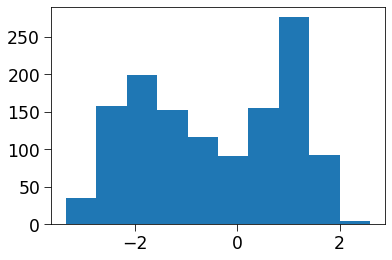

In [43]:
plt.hist(w1[4])

In [35]:
w1[-1]

array([ 1.03838599, -2.17178917,  0.57492721, ...,  1.59083498,
        1.56229997,  1.61078787])

In [34]:
w2[-1]

array([ 1.03838599, -2.17178917,  0.57492721, ...,  1.59083498,
        1.56229997,  1.61078787])

In [28]:
w1[-1] - w2[-1]

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
[np.sum(w1[i] - w2[i]) for i in range(5)]

[0.0, 0.0, 0.0, 0.0, 0.0]

In [45]:
spiking_model.connections[-1].w

<synapses_4.w: array([ 1.03838599, -2.17178917,  0.57492721, ...,  1.59083498,
        1.56229997,  1.61078787])>